<a href="https://colab.research.google.com/github/Yasaman1997/16_Bit_Adder/blob/master/Bittensor_Technical_Challenge_Pruning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from collections import OrderedDict
from scipy.stats import rankdata
from numpy import linalg
 
import torch
import torch.nn as nn 
import torch.nn.functional as functional
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms, datasets

In [ ]:
input_size = 784 # input size is 28x28, or 784
num_epochs = 10
batch_size = 64
learning_rate = 0.01 
transform = transforms.ToTensor() #convert images to tensor

In [ ]:
# Model Architecture
# Biases are presumed FALSE since they have to be ignored


class Magic_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 1000, bias=False)
        self.fc2 = nn.Linear(1000, 1000, bias=False)
        self.fc3 = nn.Linear(1000, 500, bias=False)
        self.fc4 = nn.Linear(500, 200, bias=False)
        self.fc5 = nn.Linear(200, 10, bias=False)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = functional.relu(self.fc1(x))
        x = functional.relu(self.fc2(x))
        x = functional.relu(self.fc3(x))
        x = functional.relu(self.fc4(x))
        x = functional.log_softmax(self.fc5(x), dim=1)
        return x

In [ ]:
model=Magic_NN()

In [ ]:
model

Magic_NN(
  (fc1): Linear(in_features=784, out_features=1000, bias=False)
  (fc2): Linear(in_features=1000, out_features=1000, bias=False)
  (fc3): Linear(in_features=1000, out_features=500, bias=False)
  (fc4): Linear(in_features=500, out_features=200, bias=False)
  (fc5): Linear(in_features=200, out_features=10, bias=False)
)

In [ ]:
#download and process the train and test sets

trainset = datasets.FashionMNIST('.', train=True, transform=transform,download=True)
testset = datasets.FashionMNIST('.', train=False, transform=transform,download=True)

In [ ]:
#loss function : CrossEntropy
#Optimizer: Adam , Learning rate is 0.01

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
#list of indices for spliting data
indices = list(range(len(trainset)))
np.random.shuffle(indices)

#split to 80% for Train and 20% for Validation
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#prepare Data Loaders
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=batch_size)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [ ]:
#Train The Model
for epoch in range(num_epochs):
  
  #Train loss is: "loss * batch size", initialize it to 0
  train_loss = 0 

  model.train()

  for image, label in trainloader:
    # we must set the gradients to zero
    optimizer.zero_grad()
    #send the image to the network
    output = model(image)
    #calculate the loss
    loss = loss_func(output, label)
    #Backpropagation
    loss.backward()
    optimizer.step()

    #Calculate the train Loss
    train_loss += loss.item() * image.size(0)


  #evaluate the model   
  model.eval()


  #Validation Step
  valid_loss = 0 #Validation :loss * batch size
  min_valid_loss = np.Inf  #minimum value for validation loss

  for image, label in validloader:
    # forward pass the image through the network
    output = model(image)
    # Calculate the loss
    loss = loss_func(output, label)
    #Calculate the validation loss
    valid_loss += loss.item() * image.size(0)


  # Total train loss: AVG of train loss, also for validation
  train_loss = train_loss/len(trainloader.sampler)
  valid_loss = valid_loss/len(validloader.sampler)


  print('Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f}'.format(epoch+1, train_loss,valid_loss))
    
  # save model only if validation loss has decreased
  if valid_loss <= min_valid_loss:
      print('Validation loss decreased ({} : {}).  Save model!'.format(min_valid_loss,valid_loss))
      torch.save(model.state_dict(), 'model.pt')
      min_valid_loss = valid_loss

Epoch: 1 	Training Loss: 0.9575 	Validation Loss: 0.6612
Validation loss decreased (inf : 0.661185426513354).  Save model!
Epoch: 2 	Training Loss: 0.6453 	Validation Loss: 0.6523
Validation loss decreased (inf : 0.6523093454440435).  Save model!
Epoch: 3 	Training Loss: 0.6513 	Validation Loss: 0.6256
Validation loss decreased (inf : 0.6255972702900569).  Save model!
Epoch: 4 	Training Loss: 0.5657 	Validation Loss: 0.5719
Validation loss decreased (inf : 0.5719396671454112).  Save model!
Epoch: 5 	Training Loss: 0.5709 	Validation Loss: 0.6333
Validation loss decreased (inf : 0.6332964800198873).  Save model!
Epoch: 6 	Training Loss: 0.5656 	Validation Loss: 0.5697
Validation loss decreased (inf : 0.5697133780121804).  Save model!
Epoch: 7 	Training Loss: 0.6923 	Validation Loss: 0.5926
Validation loss decreased (inf : 0.5926126457850138).  Save model!
Epoch: 8 	Training Loss: 0.5564 	Validation Loss: 0.5713
Validation loss decreased (inf : 0.5712916107177735).  Save model!
Epoch: 9 

In [ ]:
# test 


def test(model, testloader, loss_func):
    
    test_loss = 0.0
    #number of classes, and correct predictions
    class_predicted_correct = list(0.0 for i in range(10))
    total_classes = list(0.0 for i in range(10))

    model.eval()

    for data, test_label in testloader:

        # send image as input to the model
        output = model(data)

        # calculate the loss
        loss = loss_func(output, test_label)
      
        # Test loss : loss * data size
        test_loss += loss.item()*data.size(0)

        # output probabilities must be converted to a class
        _, pred = torch.max(output, 1)

        # compare prediction with true label
        correct = np.squeeze(pred.eq(test_label.data.view_as(pred)))

        # calculate accuracy for each object class
        for i in range(len(test_label)):
            label = test_label.data[i]

            class_predicted_correct[label] += correct[i].item()
            total_classes[label] += 1

    # AVG accuracy
    overall_accuracy = 100. * np.sum(class_predicted_correct) / np.sum(total_classes)
    return overall_accuracy

In [ ]:
accuracy_wp = []
accuracy_np = []

#accuracy without pruning 
initial_accuracy = test(model, testloader, loss_func)
accuracies_wp.append(initial_accuracy)
accuracies_np.append(initial_accuracy)

In [ ]:
#pruning
prune_percentage = [.0, .25, .50, .60, .70, .80, .90, .95, .97, .99]

In [ ]:
# Weight Pruning

# Loop through each prune percent
for k in prune_percentage[0:]:

    # load the trained unprunned model
    model = Magic_NN()
    model.load_state_dict(torch.load('model.pt'))

    # Get all the weights
    weights = model.state_dict()

    # keys to access model weights
    layers = list(model.state_dict())
    ranks = {} 
    pruned_weights = []

    # For each layer of network(except output)
    for l in layers[:-1]:
        # weights for each layer + convert to numpy 
        data = weights[l]
        w = np.array(data)

        # Rank the weights element
        ranks[l]=(rankdata(np.abs(w), method='dense') - 1).astype(int).reshape(w.shape)

        # Get the threshold value based on the value of k(prune percentage) 
        lower_bound_rank = np.ceil(np.max(ranks[l]) * k).astype(int)

        # Assign rank elements to 0 that are less than or equal to the threshold and 1 to those that are above.
        ranks[l][ranks[l] <= lower_bound_rank] = 0
        ranks[l][ranks[l] > lower_bound_rank] = 1

        # Multiply weights array with ranks to zero out the lower ranked weights
        w = w * ranks[l]

        # Assign the updated weights as tensor to data and append to the pruned_weights list 
        data[...] = torch.from_numpy(w)
        pruned_weights.append(data)

    # Append the last layer weights as it is
    pruned_weights.append(weights[layers[-1]])

    # Update the model weights with all the updated weights 
    new_state_dict = OrderedDict()

    #saving model state after prunning
    for l, pw in zip(layers, pruned_weights):
      new_state_dict[l] = pw
    model.state_dict = new_state_dict

    # append the test accuracy to accuracies_wp
    accuracy_wp.append(test(model, testloader, loss_func))

In [ ]:
accuracy_wp

[79.8, 79.64, 79.62, 79.66, 79.72, 79.7, 79.52, 79.17, 70.86, 29.43]

In [ ]:
# Neuron Pruning


for k in prune_percentage[0:]:
   # load the trained unprunned model
    model = Magic_NN()
    model.load_state_dict(torch.load('model.pt'))

    # Get all the weights
    weights = model.state_dict()
    layers = list(model.state_dict())
    ranks = {}
    pruned_weights = []

    # For each layer of network(except output)
    for l in layers[:-1]:
      # weights for each layer + convert to numpy 
        data = weights[l]
        w = np.array(data)

        # taking norm for each neuron
        norm = linalg.norm(w, axis=0)

        # repeat the norm values to get the shape similar to that of layer weights
        norm = np.tile(norm, (w.shape[0],1))

        # Rank the weights element
        ranks[l] = (rankdata(norm, method='dense') - 1).astype(int).reshape(norm.shape)

        # Get the threshold value based on the value of k(prune percentage) 
        lower_bound_rank = np.ceil(np.max(ranks[l])*k).astype(int)

        # Assign rank elements to 0 that are less than or equal to the threshold and 1 to those that are above.         
        ranks[l][ranks[l] <= lower_bound_rank] = 0
        ranks[l][ranks[l] > lower_bound_rank] = 1

        # Multiply weights array with ranks to zero out the lower ranked weights
        w = w * ranks[l]

        # Assign the updated weights as tensor to data and append to the pruned_weights list 
        data[...] = torch.from_numpy(w)

        # Append the last layer weights as it is
        pruned_weights.append(data)


    # Append the last layer weights as it is
    pruned_weights.append(weights[layers[-1]])


    # Update the model weights with all the updated weights 
    new_state_dict = OrderedDict()

    #saving model state after prunning
    for l, pw in zip(layers, pruned_weights):
      new_state_dict[l] = pw

    model.state_dict = new_state_dict
    accuracy_np.append(test(model, testloader, loss_func))

In [ ]:
accuracies_np

[82.43,
 78.14,
 69.94,
 58.73,
 53.09,
 51.94,
 42.9,
 31.66,
 22.73,
 13.75,
 82.41,
 10.0,
 10.0,
 67.23,
 13.75,
 67.23,
 13.75,
 82.43,
 79.8]

plot showing the percent sparsity (number of weights in the network that are zero) versus percent accuracy with two curves (one for weight pruning and one for unit pruning)

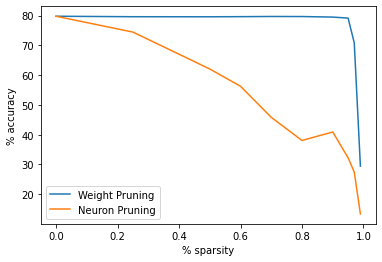

In [ ]:
# Plot the sparsity vs accuracy graph

import matplotlib.pyplot as plt

plt.plot(prune_percentage, accuracy_wp, label='Weight Pruning')
plt.plot(prune_percentage, accuracy_np, label='Neuron Pruning')
plt.legend(loc='best')
plt.xlabel('% sparsity')
plt.ylabel('% accuracy')
plt.show()

In Weight prunning: As we increase the percentage of pruning/sparsity, the perormance will not degrade even if we prune a large portion of weights(96%), which is great!

In Neuron Prunning: As we increase the percentage of pruning/sparsity, the perormance will degrade, but we still can reduce the size of model to 40% and still have the 70% accuracy, which is great!

"Both types of pruning simplify network structure, but  nodes pruning does better job. While weights pruning can give better results at cost of  more complex ANN structure and higher   computational time. Of course  if some  data  set  have complex structure – in such cases both  approaches will end up  with   only  slightly  pruned   neural   network   – but  with   better generalization   value."


Source: https://www.researchgate.net/publication/281431594_Neurons_vs_Weights_Pruning_in_Artificial_Neural_Networks

**Interesting Insights:**
============================


"It is often unclear whether a network has learned a solution which will generalise to new situations or not. By deleting progressively larger and larger groups of neurons, we found that networks which generalise well were much more robust to deletions than networks which simply memorised images that were previously seen during training. In other words, networks which generalise better are harder to break (although they can definitely still be broken). "


"These findings demonstrate the power of using techniques inspired by experimental neuroscience to understand neural networks. Using these methods, we found that highly selective individual neurons are no more important than non-selective neurons, and that networks which generalise well are much less reliant on individual neurons than those which simply memorise the training data. These results imply that individual neurons may be much less important than a first glance may suggest."

Source: https://deepmind.com/blog/article/understanding-deep-learning-through-neuron-deletion



"This has been observed in several papers and can be interpreted as a post-training network regularization. Even if you’re not looking to compress your model, you might want to have a go at pruning as a way to improve its generalization performance."

Source: https://blog.dataiku.com/making-neural-networks-smaller-for-better-deployment-solving-the-size-problem-of-cnns-using-network-pruning-with-keras

================================================================

I found this article interesting about speeding up the execution of neural networks:

https://ai.googleblog.com/2021/03/accelerating-neural-networks-on-mobile.html